Durch das Verfahren wird das nicht umbedingt Stationär.
Leon:
zeitreihen sind zufall
wenn ich zufall aus zufall ziehe verliere ich den bezug zwischen den variablen?


vorher saisonalität und marketing aktionen rausrechnen -> demand prediction auf stationärer Zeireihe machen!

Brutto Nachfrage = quasi was wir bestellen müssen -> Basis für Gewinnberechnung
Netto Nachfrage = Nachfrage mit Retouren -> ist höher, da Artikel mehfach verkauft aber auch erstattet werden können

Since these data concern a single selling season, it is not possible to do a time series analysis for each product separately.


# Scenarios
- no, low, mid, high returns (staggering return periods and rates)
- different peaks in the time series
- wie kann ich das für Marketing machen? -> muss auch nicht alles argumentieren -> marketing kann ich ja mit dem Kontext wegargumentieren
- wie soll ich das für die Saisonalität angehen? -> die müsste ja in der Nachfrageverteilung dabei sein?
- berücksichtigt unser Ansatz, dass Produkte mehrfach verkauft werden können? (ja, weil wir ja den demand immer lagged dazu packen)
- stationär mit viel und wenig varianz, saisonal (verschiedene peaks)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Set random seed for reproducibility
np.random.seed(42)

# Ideen
- die input zeitreihen
- logging für das Bootstrapping
- Storyline für DA schreiben -> prestep für die Gliederung
- Paper von Florian lesen
- Verläufe: BBM, Smooth, Midhigh, Starthigh, Endhigh
- Retouren: No, High, low

## Time dependent Bootstrap sampling

In [11]:
# ideen, versch möglichkeiten, wie die n time series verbunden werden (mean, median, weight (nähste twins haben mehr gewicht))

def bootstrap_joint_distribution(time_series, window_size: int =7, num_bootstrap_samples: int = 5000, mode: object = "random"):
    """
    Bootstraps a joint distribution from n time series with a centered sliding window.
    
    Parameters:
        time_series (list of lists): List of n time series, each of the same length.
        window_size (int): The size of the centered sliding window (default is 7).
        num_bootstrap_samples (int): Number of bootstrap samples to generate.
        mode (string): Decides how the numer of time series should be joint.

    Returns:
        type: boostrap samples.
    """
    # Ensure time series are numpy arrays
    time_series = [np.array(ts) for ts in time_series]
    length = len(time_series[0])
    n_series = len(time_series)

    # Validate input
    if not all(len(ts) == length for ts in time_series):
        raise ValueError("All time series must have the same length.")
    
    # Initialize bootstrap samples
    bootstrap_samples = []

    # Generate bootstrap samples
    for _ in range(num_bootstrap_samples):
        sample = []
        for t in range(length):
            # Determine the indices for the sliding window
            start = max(0, t - window_size // 2)
            end = min(length, t + window_size // 2 + 1)
            #print(f"start: {start} to end: {end}") funktioniert 1a, jedoch haben die edges jetzt stärkeres Gewicht/höhere zugwahrscheinlichkeit
            
            # Aggregate values across all time series within the sliding window
            if mode == "random":
                window_values = np.concatenate([ts[start:end] for ts in time_series])
                sample.append(np.random.choice(window_values))
        
        bootstrap_samples.append(np.mean(sample))

    # Convert bootstrap samples to a numpy array
    bootstrap_samples = np.array(bootstrap_samples)

    return bootstrap_samples.flatten()

#outputs:

In [3]:
time_series = [
    [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] * 5,
    [12, 22, 32, 42, 52, 62, 72, 82, 92, 102] * 5,
    [8, 18, 28, 38, 48, 58, 68, 78, 88, 98] * 5,
    [11, 21, 31, 41, 51, 61, 71, 81, 91, 101] * 5
]

In [12]:
distr = bootstrap_joint_distribution(time_series)

In [ ]:
# Assuming distr is your data
mean = np.mean(distr)
variance = np.var(distr)

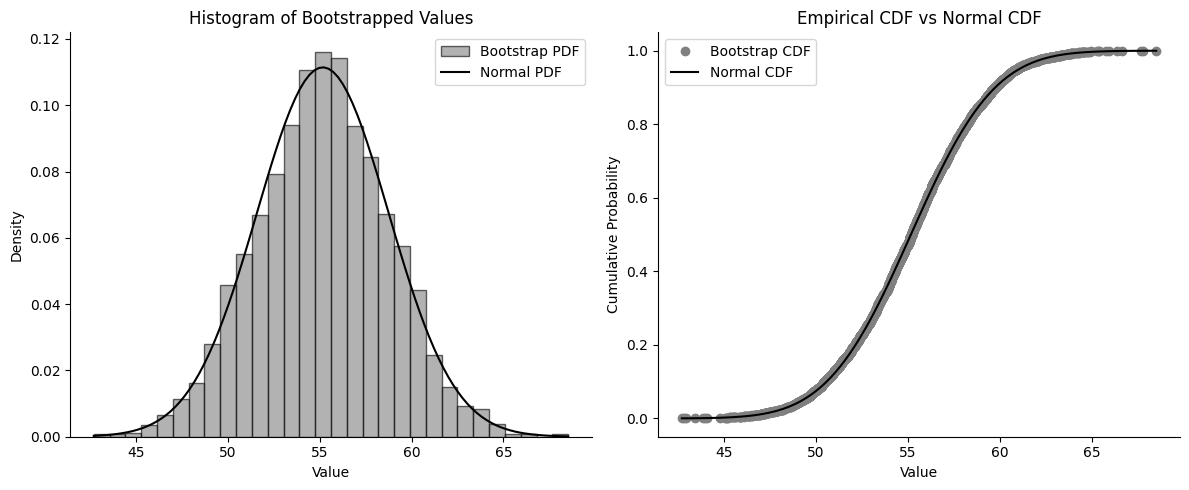

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(distr, bins=30, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(distr), max(distr), 100)
normal_pdf = stats.norm.pdf(x, loc=mean, scale=np.sqrt(variance))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(distr)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=mean, scale=np.sqrt(variance))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


In [ ]:
# Abgleich mit realer Verteilung
#-> brauchen wir korrekturfaktor